In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#export
from exp.nb_06 import *

## Let's start with a basic ConvNet

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)

In [6]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [7]:
nh, bs = 50, 512

In [8]:
c = y_train.max().item() + 1

In [9]:
loss_func = F.cross_entropy

In [10]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [11]:
nfs = [8, 16, 32, 64, 64]

In [12]:
mnist_view = view_tfm(1, 28, 28)

In [13]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [14]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [15]:
%time run.fit(2, learn)

train: [0.9186146875, tensor(0.7109, device='cuda:0')]
valid: [0.2079652099609375, tensor(0.9395, device='cuda:0')]
train: [0.162809189453125, tensor(0.9510, device='cuda:0')]
valid: [0.129499462890625, tensor(0.9594, device='cuda:0')]
CPU times: user 4.28 s, sys: 685 ms, total: 4.96 s
Wall time: 4.99 s


# Batchnormalization
## Build the layer from scratch

Why use `nn.Module.register_buffer`?
* Anything that is registered as a buffer is moved to GPU when the model is moved there
* `register_buffer` causes the means and vars to be saved with the model because we need them for inference even though they are not parameters

In [25]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # Important: PyTorch's bn mom is 1 - what you would expect
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        
        # Exponentially decaying running average using linear interpolation
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m)/ (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [53]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # We don't need bias if we use batchnorm
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)
    ]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [16]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [55]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

**Without BatchNorm:**

train: [2.097093125, tensor(0.2542, device='cuda:0')]
valid: [1.6073318359375, tensor(0.4808, device='cuda:0')]


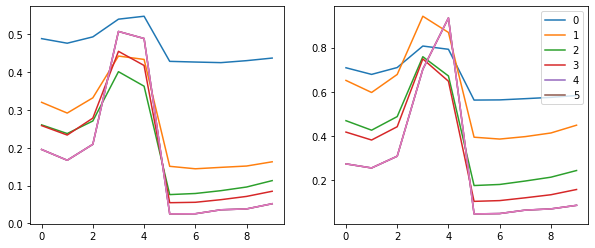

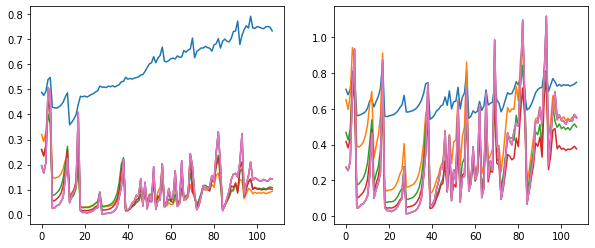

In [51]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats  # means and stds
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats  # means and stds
        ax0.plot(ms)
        ax1.plot(ss)

**With BatchNorm:**

train: [0.263823359375, tensor(0.9183, device='cuda:0')]
valid: [0.372548779296875, tensor(0.8931, device='cuda:0')]


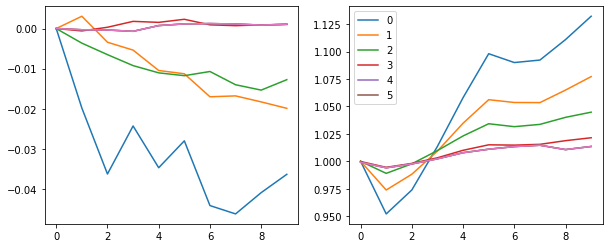

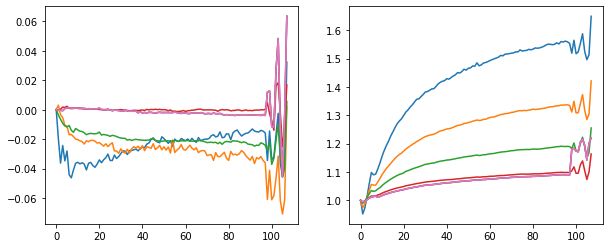

In [56]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats  # means and stds
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats  # means and stds
        ax0.plot(ms)
        ax1.plot(ss)

**Compare the results with and without bathnorm:**

**The plots show that the means of the convlayers stay approximately near 0 and the standard deviations "approximately" close to 1 when using bn. In addition, this exponential exploding and collapsing of the means and stds ins gone!**

In [57]:
learn.model[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm()
)

In [40]:
%time run.fit(3, learn)

train: [0.08772517578125, tensor(0.9734, device='cuda:0')]
valid: [0.09681576538085937, tensor(0.9699, device='cuda:0')]
train: [0.0647620654296875, tensor(0.9804, device='cuda:0')]
valid: [0.0721250732421875, tensor(0.9777, device='cuda:0')]
train: [0.05209759765625, tensor(0.9843, device='cuda:0')]
valid: [0.07195598754882812, tensor(0.9778, device='cuda:0')]
CPU times: user 3.44 s, sys: 166 ms, total: 3.61 s
Wall time: 3.61 s


## Use PyTorch's batchnorm

In [45]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # We don't need bias if we use batchnorm
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)
    ]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [46]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [47]:
%time run.fit(3, learn)

train: [0.277442890625, tensor(0.9158, device='cuda:0')]
valid: [0.10708326416015625, tensor(0.9666, device='cuda:0')]
train: [0.0796180029296875, tensor(0.9756, device='cuda:0')]
valid: [0.084092822265625, tensor(0.9743, device='cuda:0')]
train: [0.0574028955078125, tensor(0.9809, device='cuda:0')]
valid: [0.07287931518554687, tensor(0.9784, device='cuda:0')]
CPU times: user 3.06 s, sys: 154 ms, total: 3.22 s
Wall time: 3.22 s


## With scheduler

Adding some warming-up and annealing:

In [58]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2), sched_lin(2., 0.1)])

In [59]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [62]:
run.fit(8, learn)

train: [0.326405703125, tensor(0.8999, device='cuda:0')]
valid: [0.413034521484375, tensor(0.8754, device='cuda:0')]
train: [0.186992890625, tensor(0.9426, device='cuda:0')]
valid: [0.11085924072265625, tensor(0.9687, device='cuda:0')]
train: [0.0760204248046875, tensor(0.9763, device='cuda:0')]
valid: [0.219080517578125, tensor(0.9321, device='cuda:0')]
train: [0.0498154150390625, tensor(0.9842, device='cuda:0')]
valid: [0.0807989501953125, tensor(0.9765, device='cuda:0')]
train: [0.03626512939453125, tensor(0.9890, device='cuda:0')]
valid: [0.06191944580078125, tensor(0.9817, device='cuda:0')]
train: [0.0276251025390625, tensor(0.9917, device='cuda:0')]
valid: [0.05927352294921875, tensor(0.9824, device='cuda:0')]
train: [0.0220782080078125, tensor(0.9938, device='cuda:0')]
valid: [0.04909529113769531, tensor(0.9860, device='cuda:0')]
train: [0.018203160400390626, tensor(0.9950, device='cuda:0')]
valid: [0.04643385314941406, tensor(0.9869, device='cuda:0')]


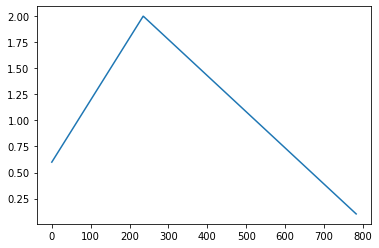

In [63]:
run.recorder.plot_lr()

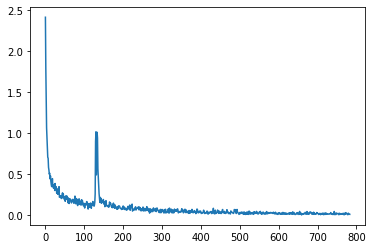

In [66]:
run.recorder.plot_loss()

## Additional normalization layers

Batchnorm has a problem:

* Cannot be applied to online learning tasks. When batch size is 1, what is the variance of that batch? 0!
* When doing segmentation you sometimes use very small batch sizes of i.e. 2 or 3. If the images are very similar you get a vanishing variance by which you divide. Not good.

**Unstable when using small batch sizes.**

* Not at all clear how bn could be inserted into RNNs

![](pictures/norms.png)

* BatchNorm: averages over batch, height, width; different for each channel
* LayerNorm: averages over each channel, height, width; different for each element of batch
* InstanceNorm: averages over height, width; different for each channel and element of batch
* GroupNorm: Same as InstanceNorm but a few channels are arbitrarily grouped together

### Layer Norm

* No moving average needed because not averaged over batch dimension

In [83]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(tensor(1.))
        self.adds  = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)  # has shape [bs, 1, 1, 1]
        v = x.var ((1, 2, 3), keepdim=True)
 
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [84]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # We don't need bias if we use batchnorm
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)
    ]
    if bn: layers.append(LayerNorm(nf))
    return nn.Sequential(*layers)

In [85]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [86]:
%time run.fit(3, learn)

train: [nan, tensor(0.1551, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.85 s, sys: 82.7 ms, total: 3.93 s
Wall time: 3.93 s


Does not work even with a slightly lower learning rate (use 0.1 to make it work). Not as good as BN! Best for RNNs though.

**Why not working? Consider the following thought experiment: We try to classifiy foggy and sunny days and apply LayerNorm before the first conv layer. Foggy days will have lower means (less bright) and lower variance (lower contrast). LayerNorm causes the means and variances to be the same for sunny and foggy images. We can't distinguish anymore!**

**If you care about the overall amount of activation or the variance in activation, don't use LayerNorm because it throws this info away!**

### Instance Norm
Similar to Layer Norm but averages only over height, width, thus, is different for each channel and element of batch.

In [97]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        
    def forward(self, x):
        m = x.mean((2, 3), keepdim=True)  # has shape [bs, nf, 1, 1]
        v = x.var ((2, 3), keepdim=True)
 
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [98]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # We don't need bias if we use batchnorm
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)
    ]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [101]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [102]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.21 s, sys: 63.9 ms, total: 4.27 s
Wall time: 4.27 s


Why can't we classify? We throw away the differences in means and variances for every channel and every image. We literally threw everything away that allows us to classify.

Why is this done then? Was not designed for classification but for *style transfer*. 

### GroupNorm
[Paper](https://arxiv.org/pdf/1803.08494.pdf)

More general approach. Can be converted into InstanceNorm or LayerNorm depending on how the channels are grouped together.

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. $\gamma$ and $\beta$ are learnable per-channel affine transform parameter vectorss of size num_channels if `affine` is `True`.

This layer uses statistics computed from input data in both training and evaluation modes.

Args:

* num_groups (int): number of groups to separate the channels into
* num_channels (int): number of channels expected in input
* eps: a value added to the denominator for numerical stability. Default: 1e-5
* affine: a boolean value that when set to True, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases). Default: True.

Shape:

* Input: (N, num_channels, *)
* Output: (N, num_channels, *) (same shape as input)

Examples::
```
>>> input = torch.randn(20, 6, 10, 10)
>>> # Separate 6 channels into 3 groups
>>> m = nn.GroupNorm(3, 6)
>>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
>>> m = nn.GroupNorm(6, 6)
>>> # Put all 6 channels into a single group (equivalent with LayerNorm)
>>> m = nn.GroupNorm(1, 6)
>>> # Activating the module
>>> output = m(input)
```

All these Papers presented work arounds for the problem that we can't use small batch sizes and can't use RNNs with bathnorm. However, none of them are as good as batchnorm.

What do we do? Well, we cannot fix the RNN problem at this point but we can fix the small bs problem!

## Fix small batch sizes
When we compute the mean and std for a BatchNorm Layer on a small batch, it is possible that we get a deviation very close to 0.

In [21]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

Batch size of 2

In [22]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [23]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [24]:
%time run.fit(1, learn)

train: [2.3262346875, tensor(0.1888, device='cuda:0')]
valid: [83101.6192, tensor(0.1966, device='cuda:0')]
CPU times: user 1min 53s, sys: 1.45 s, total: 1min 55s
Wall time: 1min 55s


After one epoch we only have around 20% accuracy. We should be much better after one epoch if we compare to the runs before. The reason is the small batch size! If the variance gets small for a batch, the activations explode.

**First idea, set eps to 0.01**

In [25]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=0.01, momentum=0.1))
    return nn.Sequential(*layers)

In [26]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [27]:
%time run.fit(1, learn)

train: [2.306885625, tensor(0.1811, device='cuda:0')]
valid: [2.061930859375, tensor(0.2204, device='cuda:0')]
CPU times: user 1min 55s, sys: 1.42 s, total: 1min 57s
Wall time: 1min 57s


Not really better

**Better idea:**
### Running Batch Norm
**Use the running averages of the mean and std also during training!**

The variance is:
\begin{equation}
\operatorname{Var}(X)=\operatorname{E}[X^2]-\operatorname{E}[X]^2
\end{equation}

Instead of keeping track of a running mean of the variance, let's keep track of a running mean of the sums $X$ and the sqrs $X^2$ and then use those to calculate the variance:

In [28]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        
        # initialize the running averages to 0 and then "debias"
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))  # running average of sum of activations per ch
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))  # running average of sum of squares per ch
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))  # running average of height * with * batch size
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)       # calculate the sum of the activations per channel over b, h, w
        ss = (x*x).sum(dims, keepdim=True)  # calculate the sum of the squares of the acts per channel
        c = self.count.new_tensor(x.numel() / nc)  # height * with * batch size
                                                   # reason: we average over batch, height, width
        
        mom1 = 1 - (1 - self.mom)/math.sqrt(bs - 1)  # ?
        self.mom1 = self.dbias.new_tensor(mom1)
        
        self.sums.lerp_(s, self.mom1)  # linear interpolation to update the running average of the sums
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        
        self.dbias =  self.dbias * (1-self.mom1) + self.mom1  # ?
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias  # divide by debiasing amount because running averages are initialized to 0
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        
        # Var(x) = E(x^2) - E(x)^2
        means = sums/c
        vars  = (sqrs/c).sub_(means*means)
        
        if bool(self.batch < 20): vars.clamp_min_(0.01) # avoids getting unlucky if small variance in first batches
        
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        
        return x.mul_(self.mults).add_(self.adds)

In [29]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [32]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [33]:
%time run.fit(1, learn)

train: [0.732570859375, tensor(0.7902, device='cuda:0')]
valid: [23148403.0976, tensor(0.9126, device='cuda:0')]
CPU times: user 4min 42s, sys: 2.67 s, total: 4min 44s
Wall time: 4min 45s


### What's the best result we can get after a single epoch?

In [34]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [35]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs + [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [36]:
%time run.fit(1, learn)

train: [0.156132041015625, tensor(0.9516, device='cuda:0')]
valid: [0.06525264282226563, tensor(0.9803, device='cuda:0')]
CPU times: user 18.3 s, sys: 205 ms, total: 18.5 s
Wall time: 18.5 s


## 98% after one epoch!!

## Export

In [3]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exp/nb_07.py
